In [9]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.stats import spearmanr

import plotting_functions as pf
import analysis_functions as af
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


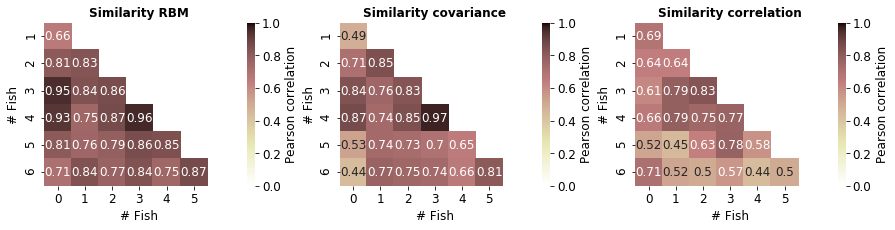

In [251]:
dict_reproducibility = af.load_reprod_matrix(swap=True, 
                                             path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

fig = plt.figure(constrained_layout=False, figsize=[15, 3])
ax_sim = {}
for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
    ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
    pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key=plot_name,
                         ax=ax_sim[i_plot])
    ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

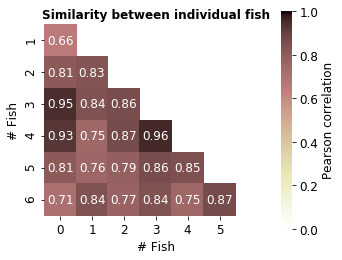

In [252]:
dict_reproducibility = af.load_reprod_matrix(swap=True, 
                                             path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

fig = plt.figure(constrained_layout=False, figsize=[5, 4])
pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key='RBM',
                     ax=fig.add_subplot())

## Jerome's fig;

In [4]:
## Takes up 8 GB RAM
version = '2'

env = pickle.load(open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version,'rb'))

runs = env['runs'] # List of experimental recordings used.

print(f'Loaded {len(runs)} runs')

# Baier matrices.
nRegions_baier = env['nRegions_baier'] # 72
assert nRegions_baier == 72
region_names_baier = env['region_names_baier'] # the region names, in the order displayed.

'''
There are various Baier matrices:
- his old version.
- his new version.
- the ones I rederived from his new data.
All viz are made with 'my_new_normalized_by_volume', but we can change at last stage if needed.
'''
selected_connectivity_type = 'my_new_normalized_by_volume'
connectivity_baier = env['connectivity_baier'] # The selected one.
all_baier_connectivities = env['all_baier_connectivities'] # All others.
connectivity_types = list(all_baier_connectivities.keys()) 

nNeurons_per_region = env['nNeurons_per_region'] # Number of neurons / region / recording.
mean_nNeurons_per_region = env['mean_nNeurons_per_region'] # Averaged number of neurons (across all recordings)


all_functional_connectivities = env['all_functional_connectivities']  # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.

all_averaged_functional_connectivities = env['all_averaged_functional_connectivities'] # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.
if 'all_neuron_connectivities' in env.keys():
    all_neuron_connectivities = env['all_neuron_connectivities']
methods = env['methods']


averaging_weights = env['averaging_weights'] 
# The tensor of pair-weights used for producing the average functional connectivity (of size Nrecordings X Nregions X Nregions).



Loaded 8 runs


In [17]:
# region_names_baier  ## to write down abbreviation manually
# with open('/home/thijs/repos/zf-rbm/baier_atlas_labels/region_names_baier_abbreviations.txt', 'w') as f:
#     for name in region_names_baier:
#         f.write(name + '\n')

In [48]:
# new_env = {k: v for k, v in env.items() if k != 'all_neuron_connectivities'}  # recreate without neuron neuron connection to save space
# with open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version, 'wb') as f:
#     pickle.dump(new_env, f)

In [121]:
kunst_region_order = {}
kunst_region_order['inds'], kunst_region_order['names'] = af.create_mapping_kunstea_order(current_regions=region_names_baier)


['th' 'ts' 't' 'mos1' 'TH' 'TS' 'T' 'MOS1' 'MOS5' 'mos4' 'MOS4' 'mos5'
 'mon' 'MON' 'Ce' 'ce' 'MOS3' 'mos3' 'Pr' 'pr' 'Hi' 'Nln' 'Hc' 'hc' 'hi'
 'nln' 'Po' 'po' 'PT' 'pt' 'P' 'p' 'S' 's' 'mos2' 'MOS2' 'vr' 'OG' 'TG'
 'tg' 'gg' 'GG' 'OE' 'oe' 'VR' 'og' 'IO' 'nx' 'NX' 'io' 'Ret' 'tl' 'TL'
 'ret' 'pit' 'Pit' 'Hr' 'hr' 'TeO' 'teo' 'OB' 'ob' 'ha' 'Ha' 'irf' 'prf'
 'r' 'R' 'iRF' 'pRF' 'arf' 'aRF']


In [5]:

aggregations = [1, 2]
selected_aggregation = 1 # Use L1 norm for the averaged.


# output_folder = 'plots_v%s/'%version
# if not os.path.isdir(output_folder):
#     os.mkdir(output_folder)
output_folder = '/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/'


'''
Determine "subset", the subset of regions onto which we perform analysis.
Here: At least 5 neurons on average for both the left and right region.
'''
Nmin = 5
subset = np.zeros(nRegions_baier, dtype='bool')
for i in range(nRegions_baier // 2):
    if (mean_nNeurons_per_region[2 * i] >= Nmin) & (mean_nNeurons_per_region[2 * i + 1] >= Nmin):
        subset[2 * i] = 1
        subset[2 * i + 1] = 1
subset = np.nonzero(subset)[0]

'''
Determine the recording-level subset of regions. Useful for pairwise comparison and recording visualization.
'''
nNeurons_per_region_symmetrical = np.concatenate([np.concatenate([nNeurons_per_region[2*i+1:2*i+2,:],
                                                                  nNeurons_per_region[2*i:2*i+1]], axis=0) for i in range(nRegions_baier//2)], axis=0)
relevant_regions = np.zeros(nNeurons_per_region.shape, dtype=bool)
relevant_regions[subset,:] = (nNeurons_per_region[subset, :] >= Nmin) & (nNeurons_per_region_symmetrical[subset, :] >= Nmin)
relevant_regions2 = relevant_regions[:, np.newaxis] * relevant_regions[np.newaxis, :, :]    
nRuns = len(runs)    
all_masks = relevant_regions2.reshape([nRegions_baier ** 2, nRuns]).T 


In [266]:
## show single dataset heatmaps
all_spearman = {}
all_pearson = {}
all_spearman_averaged = {}
all_pearson_averaged = {}
connectivity_key_format = 'run:{run}_method:{method}_agg:{aggregation}'
correlation_key_format = 'run:{run}_method:{method}_agg:{aggregation}_conn:{connectivity_type}'
averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}'
correlation_averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}_conn:{connectivity_type}'

# Compute spearman and pearson correlation.

for k, run in enumerate(runs):
    for method in methods:
        for aggregation in aggregations:
            key_dict = connectivity_key_format.format(
                run=run, method=method, aggregation=aggregation)
            prediction = all_functional_connectivities[key_dict].copy()
            for connectivity_type in connectivity_types:
                target = all_baier_connectivities[connectivity_type].copy()
                if connectivity_type in ['his_old', 'his_new']:
                    target[np.arange(len(target)), np.arange(
                        len(target))] += 1.0 * target.max()  # They did not define a diagonal connexion (intra-region connectivity). Set to the maximum value across all entry.

                flat_target = target.flatten()[all_masks[k]]
                flat_prediction = prediction.flatten()[all_masks[k]]
                # flat_target = target[subset, :][:, subset].flatten()
                # flat_prediction = prediction[subset,
                #                              :][:, subset].flatten()
                spearman = spearmanr(
                    flat_target, flat_prediction).correlation
                pearson = np.corrcoef(
                    flat_target, flat_prediction)[0, 1]

                key = correlation_key_format.format(
                    run=run, method=method, aggregation=aggregation, connectivity_type=connectivity_type)
                all_spearman[key] = spearman
                all_pearson[key] = pearson

# Compute average spearman and pearson correlation.
for connectivity_type in connectivity_types:
    for method in methods:
        for aggregation in aggregations:
            prediction = all_averaged_functional_connectivities[averaged_connectivity_key_format.format(
                method=method, aggregation=aggregation)]
            target = all_baier_connectivities[connectivity_type].copy()
            if connectivity_type in ['his_old', 'his_new']:
                target[np.arange(len(target)), np.arange(
                    len(target))] += 1.0 * target.max()

            flat_target = target[subset, :][:, subset].flatten()
            flat_prediction = prediction[subset,
                                         :][:, subset].flatten()

            spearman = spearmanr(
                flat_target, flat_prediction).correlation
            pearson = np.corrcoef(flat_target, flat_prediction)[0, 1]

            key = correlation_averaged_connectivity_key_format.format(
                method=method, aggregation=aggregation,connectivity_type=connectivity_type)
            all_spearman_averaged[key] = spearman
            all_pearson_averaged[key] = pearson

# Make region filters.
all_correlations = {}   
for method in methods:
    correlation = np.zeros([nRuns,nRuns])
    for k1,run1 in enumerate(runs):
        for k2,run2 in enumerate(runs):
            key1 = 'run:%s_method:%s_agg:%s'%(run1,method,selected_aggregation)
            key2 = 'run:%s_method:%s_agg:%s'%(run2,method,selected_aggregation)
            connections1 = all_functional_connectivities[key1].flatten()
            connections2 = all_functional_connectivities[key2].flatten()
            mask = all_masks[k1] & all_masks[k2]
            correlation[k1,k2] = np.corrcoef(connections1[mask],connections2[mask])[0,1]
            # correlation[k1,k2] = (connections1[mask]*connections2[mask]).mean()/np.sqrt( (connections1[mask]**2).mean() * (connections2[mask]**2).mean() )
    all_correlations[method] = {'pearson': correlation, 'run_names': runs}

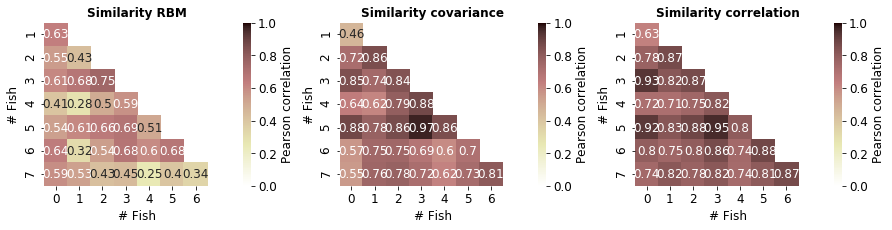

In [258]:
fig = plt.figure(constrained_layout=False, figsize=[15, 3])
ax_sim = {}
for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
    ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
    pf.plot_reproduc_mat(dict_mat=all_correlations, key=plot_name,
                         ax=ax_sim[i_plot])
    ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

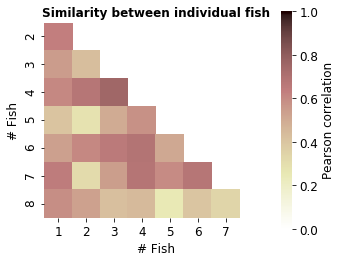

In [324]:
fig = plt.figure(constrained_layout=False, figsize=[5, 4])
pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
                     ax=fig.add_subplot())
plt.savefig('/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/similarity_individ_fish.png', dpi=300)

In [305]:
method = 'RBM'
assert selected_aggregation == 1
tmp_all_connectivity = np.zeros((len(runs), nRegions_baier, nRegions_baier))
for k, run in enumerate(runs):
    key_matrix = connectivity_key_format.format(
        run=run, method=method, aggregation=selected_aggregation)
    key_correlation = correlation_key_format.format(
        run=run, method=method, aggregation=selected_aggregation, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[k].reshape([nRegions_baier,nRegions_baier])] = np.nan
    tmp_all_connectivity[k, :, :] = prediction_

tmp = tmp_all_connectivity.flatten()
tmp = tmp[np.logical_not(np.isnan(tmp))]
tmp = np.log10(tmp)
mini = np.percentile(tmp, 10)
maxi = np.percentile(tmp, 90)
print(mini, maxi)

-5.20045633254991 -3.237469224247828


In [333]:
print(runs)
print(all_correlations['RBM']['run_names'])

['20180706_Run04', '20180911_Run01', '20180912_Run01', '20180913_Run01', '20181218_Run02', '20181206_Run03', '20190102_Run01', '20181206_Run05']
['20180706_Run04', '20180911_Run01', '20180912_Run01', '20180913_Run01', '20181218_Run02', '20181206_Run03', '20190102_Run01', '20181206_Run05']


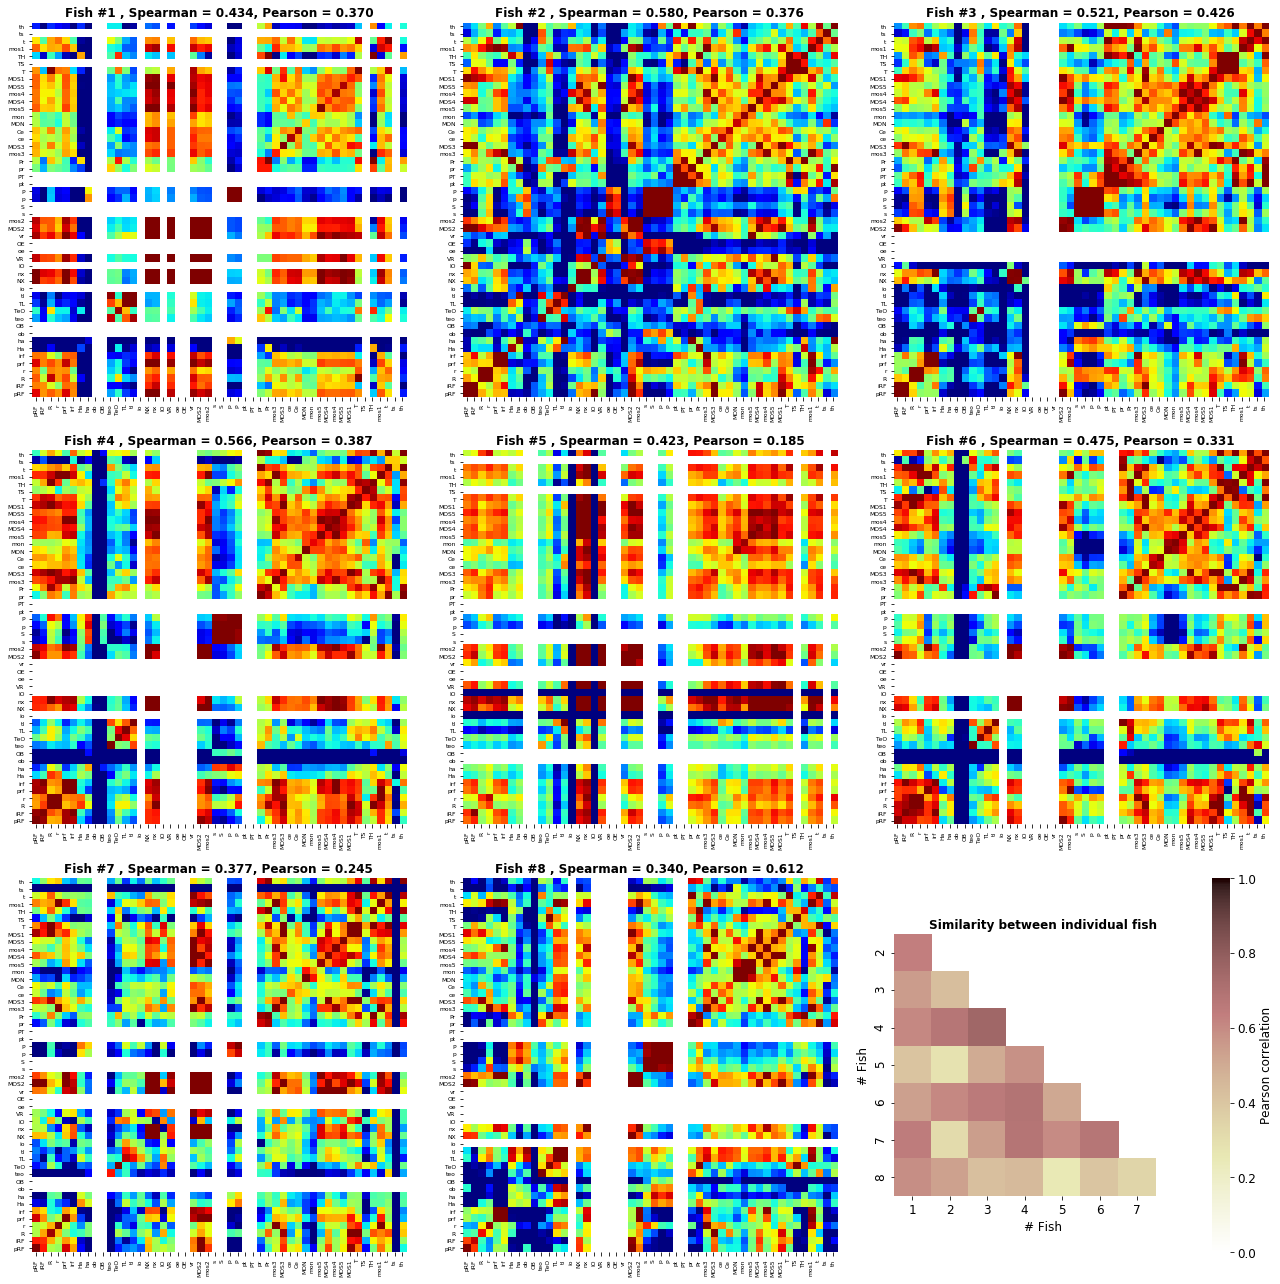

In [344]:
nRuns = len(runs)      
# for method in methodsshow_connectivity
method = 'RBM'
figure_name = 'Connectivity_all_runs_method_%s.png' %(method)
nrows = 3
ncols = int(np.ceil(nRuns/nrows))
fig, ax = plt.subplots(nrows, ncols)
fig.set_figheight(nrows * 6 )
fig.set_figwidth(ncols * 6)
for k, run in enumerate(runs):
    i = k // ncols
    j = k % ncols

    index_run = np.where(np.array(all_correlations['RBM']['run_names']) == run)[0]
    assert len(index_run) == 1
    key_matrix = connectivity_key_format.format(
        run=run, method=method, aggregation=selected_aggregation)
    key_correlation = correlation_key_format.format(
        run=run, method=method, aggregation=selected_aggregation, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[k].reshape([nRegions_baier,nRegions_baier])] = np.nan

    spearman = all_spearman[key_correlation]
    pearson = all_pearson[key_correlation]
#         prediction_ = prediction_[kunst_region_order['inds'], :][:, kunst_region_order['inds']]
    ax[i, j] = pf.plot_connectivity_matrix(prediction_, region_names_baier, #mini=mini, maxi=maxi,
                                size=5, ax=ax[i,j], subset=subset, plot_log=True, scale_limits=True,
                                region_order_dict=kunst_region_order, plot_labels=True)
#     ax[i, j].set_title('%s (%s %s), Spearman = %.3f, Pearson = %.3f' % (
#         run, method, selected_aggregation, spearman, pearson), fontsize=12)
    ax[i, j].set_title('Fish #%s , Spearman = %.3f, Pearson = %.3f' % (
        index_run[0] + 1, spearman, pearson), fontsize=12, fontdict={'weight': 'bold'})
    
pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
                 ax=ax[2, 2])
plt.tight_layout()
fig.savefig('/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/individual_rbms.png', dpi=300)


In [339]:
np.array(all_correlations['RBM']['run_names']) == run

array([ True, False, False, False, False, False, False, False])

-3 2


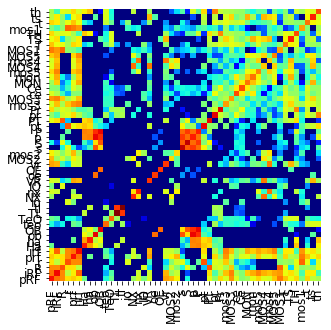

In [312]:
tmp = pf.plot_connectivity_matrix(matrix=all_baier_connectivities['my_new_normalized_by_volume'] + 1e-6, 
                                  cbar=False, plot_log=True, scale_limits=True,
                                  region_names=region_names_baier, size=5, mini=-3, maxi=2,
                                  region_order_dict=kunst_region_order, 
                                  reverse_x=True, subset=subset)
# plt.colorbar(tmp)

-5.748828322236367 -3.065701620534932


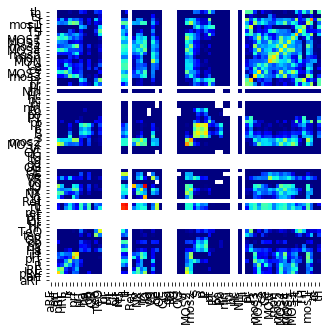

In [245]:
tmp = pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:RBM_agg:1'], 
                                  cbar=False, plot_log=True, mini=mini, maxi=maxi,
                            region_names=region_names_baier, size=5, scale_limits=True,
                                  region_order_dict=kunst_region_order, 
                                  reverse_x=True)#, subset=subset)
# plt.colorbar(tmp)

-4.7466082298828915 -3.484979103437438


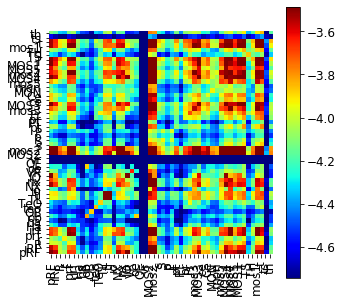

In [236]:
tmp = pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:covariance_agg:1'], 
                                  cbar=True, plot_log=True,
                            region_names=region_names_baier, size=5, scale_limits=True,
                                  region_order_dict=kunst_region_order, reverse_x=True, subset=subset)
# plt.colorbar(tmp)

In [150]:
all_averaged_functional_connectivities.keys()

dict_keys(['method:RBM_agg:1', 'method:RBM_agg:2', 'method:covariance_agg:1', 'method:covariance_agg:2', 'method:correlation_agg:1', 'method:correlation_agg:2'])

In [348]:
print(mini, maxi)

-5.20045633254991 -3.237469224247828


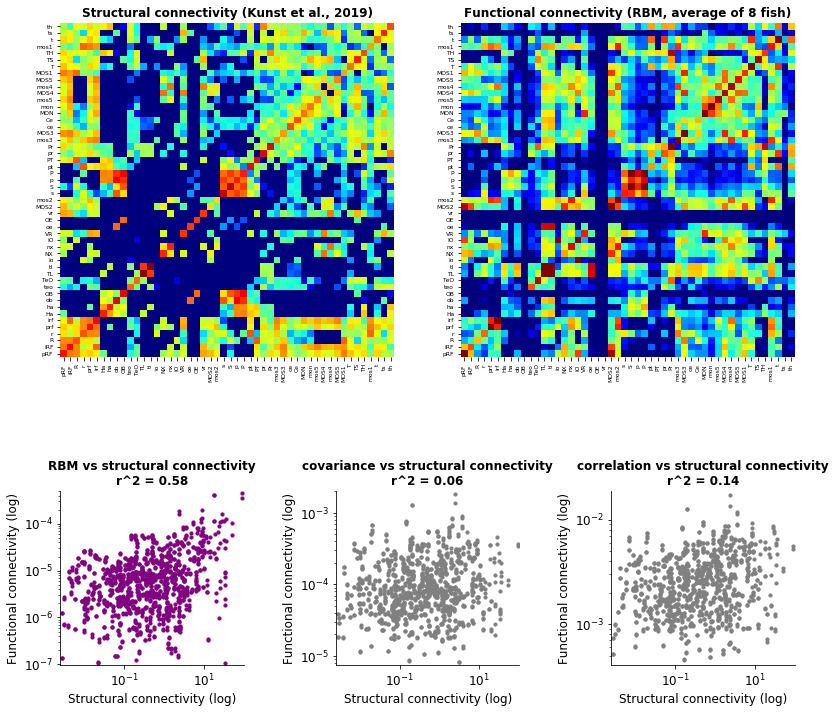

In [412]:
fig = plt.figure(figsize=[12, 11])
gs_matrices = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=0.95, top=1,
                               bottom=0.3, wspace=0.2, hspace=0)
gs_bottom = fig.add_gridspec(ncols=3, nrows=1, left=0.1, right=0.95, top=0.27, bottom=0.05,
                             wspace=0.5)
ax_baier = fig.add_subplot(gs_matrices[0])
ax_rbm = fig.add_subplot(gs_matrices[1])

pf.plot_connectivity_matrix(matrix=all_baier_connectivities['my_new_normalized_by_volume'] + 1e-6, 
                          cbar=False, plot_log=True, scale_limits=True,
                          region_names=region_names_baier, mini=-3, maxi=2,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_baier)
ax_baier.set_title('Structural connectivity (Kunst et al., 2019)', 
                   fontdict={'weight': 'bold'})

pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:RBM_agg:1'], 
                          cbar=False, plot_log=True,  mini=-6, maxi=-4,
                            region_names=region_names_baier, size=5, scale_limits=True,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_rbm)

ax_rbm.set_title('Functional connectivity (RBM, average of 8 fish)', 
                 fontdict={'weight': 'bold'})

ax_comparison = {}
for i_meth, method in enumerate(['RBM', 'covariance', 'correlation']):
    ax_comparison[method] = fig.add_subplot(gs_bottom[i_meth])
    pearson = pf.plot_funct_vs_struct(struct_mat=all_baier_connectivities['my_new_normalized_by_volume'],
                            funct_mat=all_averaged_functional_connectivities[f'method:{method}_agg:1'],
                            ax=ax_comparison[method], subset=subset, key=method)
    ax_comparison[method].set_title(f'{method} vs structural connectivity\nr^2 = {np.round(pearson, 2)}',
                                    fontdict={'weight': 'bold'})
    
#     ax_comparison[method]

plt.savefig('/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/struct_funct.png', dpi=300)

In [385]:
'RBM'.lower()

'rbm'

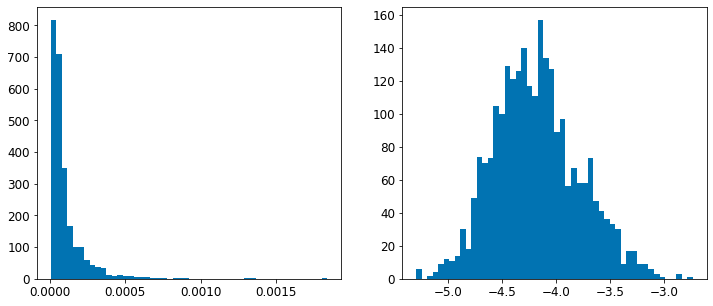

In [300]:
pf.plot_distr(all_averaged_functional_connectivities['method:covariance_agg:1'])

/home/thijs/repos/zf-rbm/figure_notebooks/plotting_functions.py:446: RuntimeWarning: invalid value encountered in greater
  mat = mat[np.where(mat > 1e-15)]


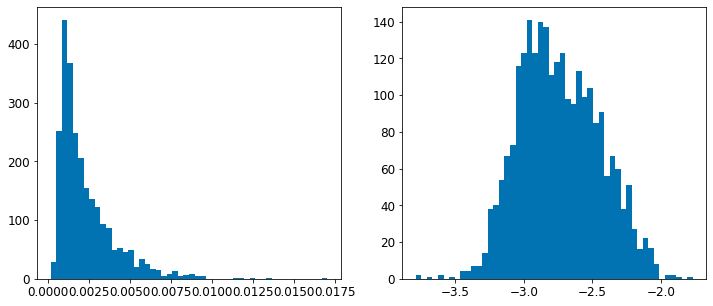

In [304]:
pf.plot_distr(all_averaged_functional_connectivities['method:correlation_agg:1'], 
              min_th=1e-4)

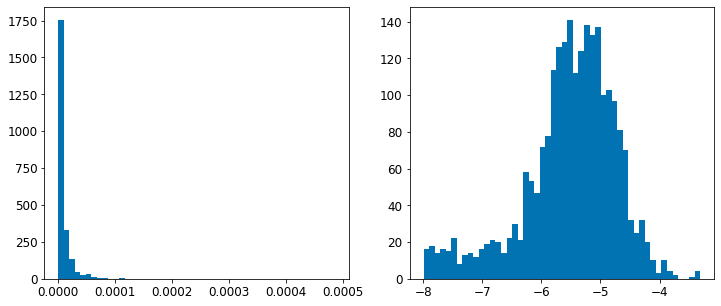

In [302]:
pf.plot_distr(all_averaged_functional_connectivities['method:RBM_agg:1'])

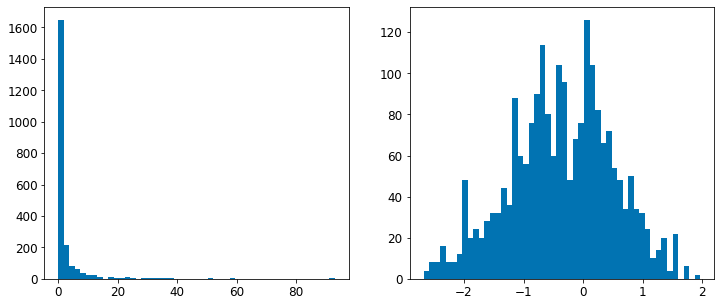

In [303]:
pf.plot_distr(all_baier_connectivities['my_new_normalized_by_volume'])